### Panorama Creation
This notebook demonstrates how to create a panorama from two images using  
SIFT keypoint detection, descriptor matching, homography estimation with RANSAC,  
and image warping with OpenCV.

In [1]:
import sys
!pip install opencv-python matplotlib
import cv2  #computer vision
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

***Load input images***    
Upload your two images in the left-side file menu in Colab.  
Name them left.jpg and right.jpg.  
These will be used to build the panorama.


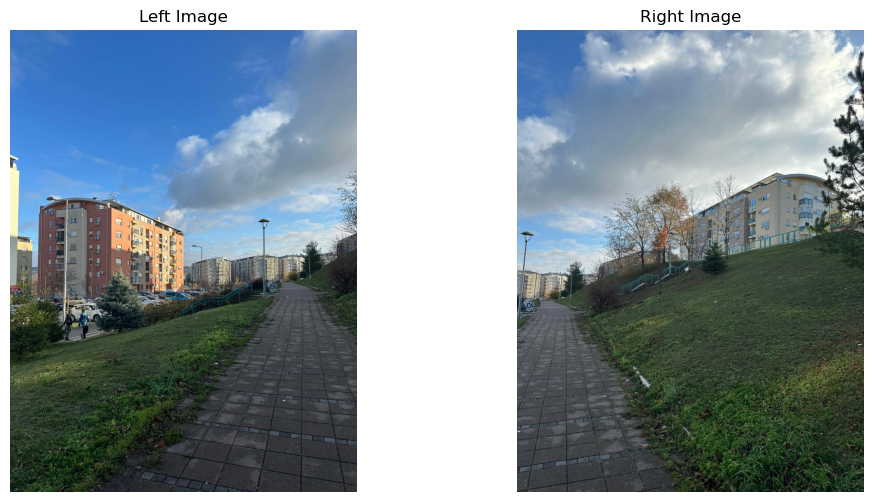

In [2]:
# Load the two images (after uploading them)
img1 = cv2.imread("left.jpg")
img2 = cv2.imread("right.jpg")

if img1 is None or img2 is None:
    raise Exception("Images not found. Upload left.jpg and right.jpg.")

# Convert to RGB for display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Convert to grayscale for SIFT
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img1_rgb); plt.title("Left Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img2_rgb); plt.title("Right Image"); plt.axis("off")
plt.show()


***SIFT Keypoint Detection***   
We use SIFT to detect distinctive points in both images and compute  
128-dimensional feature descriptors. These will later be matched between the images.

In [3]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

print("Keypoints in left image:", len(kp1))
print("Keypoints in right image:", len(kp2))

Keypoints in left image: 11527
Keypoints in right image: 14402


***Feature Matching (BFMatcher + Ratio Test)***    
We match each descriptor from image 1 to the closest descriptors in image 2.  
The ratio test removes ambiguous matches and keeps only reliable ones.


Total matches: 11527
Good matches after ratio test: 130


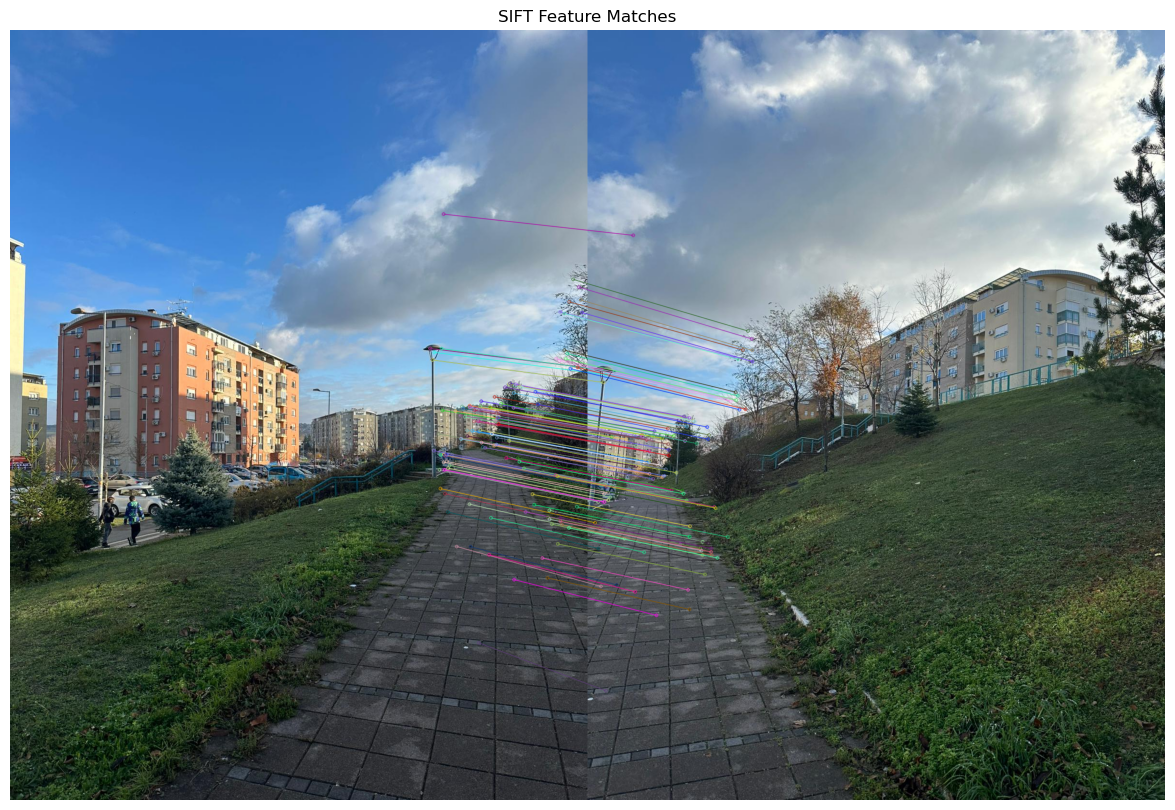

In [4]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.47 * n.distance:
        good_matches.append(m)

print("Total matches:", len(matches))
print("Good matches after ratio test:", len(good_matches))

img_matches = cv2.drawMatches(img1_rgb, kp1, img2_rgb, kp2, good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(img_matches)
plt.title("SIFT Feature Matches")
plt.axis("off")
plt.show()


***Compute Homography (RANSAC)***   
We extract the coordinates of matched keypoints and use them to compute  
a projective transformation (homography) using RANSAC to eliminate outliers.


In [5]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

print("Homography matrix H:\n", H)


Homography matrix H:
 [[ 0.35  0.17  726.90]
 [-0.54  0.93  20.56]
 [-0.00  0.00  1.00]]


***Warp the right image and blend it with the left image***   
Using the homography, we warp the right image into the coordinate system  
of the left image and blend the two images to form a panorama.

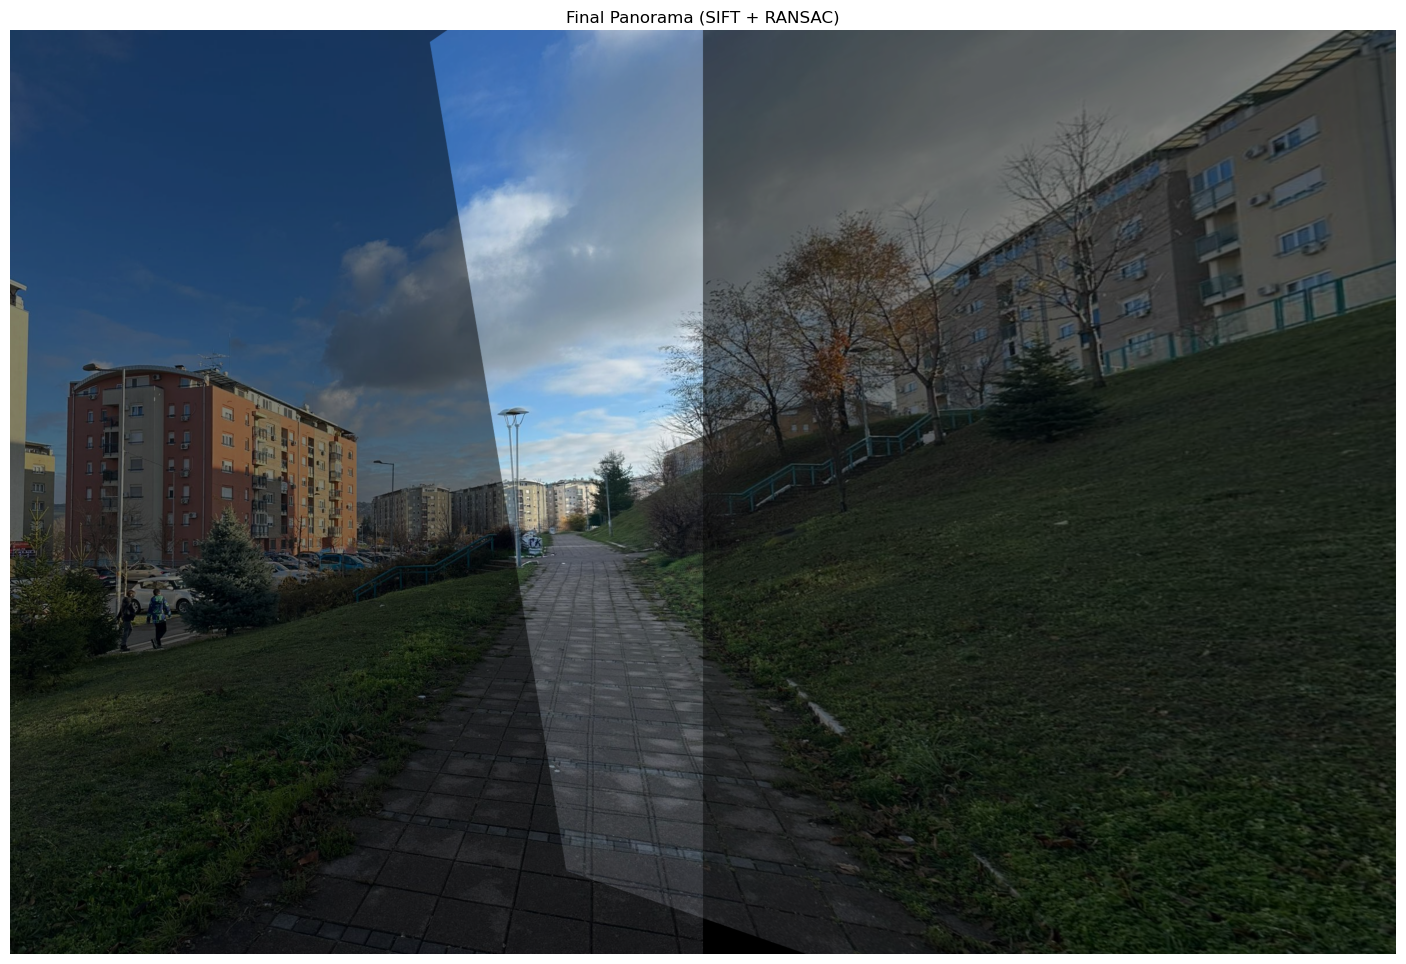

True

In [6]:
h1, w1 = img1_rgb.shape[:2]
h2, w2 = img2_rgb.shape[:2]

output_width = w1 + w2
output_height = max(h1, h2)

warped_img2 = cv2.warpPerspective(img2_rgb, H, (output_width, output_height))

panorama = np.zeros((output_height, output_width, 3), dtype=img1_rgb.dtype)
panorama[0:h1, 0:w1] = img1_rgb

# Blend left + warped right
panorama = cv2.addWeighted(panorama, 0.5, warped_img2, 0.5, 0)

plt.figure(figsize=(24,12))
plt.imshow(panorama)
plt.title("Final Panorama (SIFT + RANSAC)")
plt.axis("off")
plt.show()

cv2.imwrite("panorama_result.jpg", cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR))
